<a href="https://colab.research.google.com/github/vysf/seismologi-terapan/blob/master/LFPS_Attributes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective
## Calculating LFPS Attributes

Terdapat 4 atribute utama pada metode LFPS:
* Amplitudo ($A_1$): merupakan amplitudo tertinggi pada komponen Z pada rentang interval tertutup frekuensi anomali LFPS $[f_{min}, f_{max}]$
* Frekuensi ($A_2$): merupakan frekuensi pada saat komponen Z memiliki amplitudo tertinggi ($A_1$)
* Energi ($A_3$): merupakan luasan di bawah kurva amplitudo pada rentang frekuensi anomali LFPS, dapat dituliskan sebagai:
$A_3 = \frac{1}{f_{max}-f_{min}}\int_{f_{min}}^{f_{max}}A_1(f)df\approx \frac{1}{f_{max}-f_{min}} \sum_{i=1}^{N}A_1(i)\Delta f$
* VHSR ($A_4$): merupakan perbandingan antara komponen vertikal dan horizontal pada frekuensi $A_2$, yaitu:
$A_4=\frac{Z(A_2)}{\sqrt{(N(A_2))^2+(E(A_2))^2}}$


In [1]:
!pip install obspy

In [2]:
import obspy
import pickle
import numpy as np
import matplotlib.pyplot as plt

#Helper Function

## Peak detection

In [3]:
from scipy.signal import find_peaks

def peakdetect(x, y):
  peak_index, _ = find_peaks(y, height=0)

  highest_peak_index = np.argmax(y[peak_index])

  xmax = x[peak_index[highest_peak_index]]
  ymax = y[peak_index[highest_peak_index]]
  return xmax, ymax

# Read Data

## Observed data

In [4]:
observed_file = "temporary_prepro.mseed"
stream = obspy.read(observed_file)

In [5]:
print(f"SEISMOGRAM INFORMATION")
print(stream[2].stats)

SEISMOGRAM INFORMATION
         network: HG
         station: 16
        location: 
         channel: BHZ
       starttime: 2022-07-28T05:53:42.340000Z
         endtime: 2022-07-28T07:08:42.340000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 450001
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 7895, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 512, 'filesize': 12126720})


## Windows list

In [6]:
window_list_file = "window_list_polans.pkl"
window_length = 10 # in seconds

with open(window_list_file,'rb') as fi:
  window_list = pickle.load(fi)

In [7]:
print(f"\nWINDOWING")
print(f"Number of window: {len(window_list)}, total time: {len(window_list)*window_length/60:5.2f} minutes")


WINDOWING
Number of window: 14, total time:  2.33 minutes


# Signals Smoothing

In [8]:
from obspy.signal.konnoohmachismoothing import konno_ohmachi_smoothing as kos

## Calculate spectrum

In [9]:
def get_spectrum(trace, window_list):
  spectrum, smoothed_spectrum = [], []

  for window in window_list:
    _trimmed_signal = trace.copy().trim(window[0], window[1])
    delta = _trimmed_signal.stats.delta
    npts = _trimmed_signal.stats.npts
    fftfreq = np.fft.fftfreq(npts, delta)[:int(npts) // 2]

    res = np.abs(np.fft.fft(_trimmed_signal.data))[:int(len(fftfreq))]
    spectrum.append(res)

    smoothed_spectrum.append(
      kos(res, fftfreq,
        bandwidth=40, count=1,
        enforce_no_matrix=False,
        max_memory_usage=512,
        normalize=True)
    )
  return fftfreq, (spectrum, smoothed_spectrum)

## Calculate VHSR

In [10]:
def vhsr(fftfreq, spectrum_z, spectrum_n, spectrum_e):
  if len(spectrum_z) != len(spectrum_n) and len(spectrum_z) != len(spectrum_e):
    raise ValueError("length spectrum Z, N, and E must the same")

  spectrum_vhsr, spectrum_vhsrs = [], []

  for Z, N, E in zip(spectrum_z, spectrum_n, spectrum_e):
    res = Z / np.sqrt(N**2 + E**2)
    spectrum_vhsr.append(res)

    spectrum_vhsrs.append(
      kos(res, fftfreq,
        bandwidth=40, count=1,
        enforce_no_matrix=False,
        max_memory_usage=512,
        normalize=True)
    )

  return fftfreq, (spectrum_vhsr, spectrum_vhsrs)

In [11]:
# @title Another algorithm to calculate smoothed spectrum and VHSR
# def process_seismic_data(stream, window_list):
#   spectrum_z, spectrum_zs = [], []
#   spectrum_n, spectrum_ns = [], []
#   spectrum_e, spectrum_es = [], []
#   spectrum_vhsr, spectrum_vhsrs = [], []

#   for window in window_list:
#     _trimmed_signal = stream.copy().trim(window[0], window[1])
#     delta = _trimmed_signal[0].stats.delta
#     npts = _trimmed_signal[0].stats.npts
#     fftfreq = np.fft.fftfreq(npts, delta)[:int(npts) // 2]

#     for ic, component in enumerate(stream):
#       spectrum = np.abs(np.fft.fft(_trimmed_signal[ic].data))[:int(len(fftfreq))]
#       smoothed_spectrum = kos(spectrum, fftfreq,
#                               bandwidth=40, count=1,
#                               enforce_no_matrix=False,
#                               max_memory_usage=512,
#                               normalize=True)

#       if component.stats.channel[-1].upper() == "Z":
#         spectrum_z.append(spectrum)
#         spectrum_zs.append(smoothed_spectrum)
#       elif component.stats.channel[-1].upper() == "N":
#         spectrum_n.append(spectrum)
#         spectrum_ns.append(smoothed_spectrum)
#       elif component.stats.channel[-1].upper() == "E":
#         spectrum_e.append(spectrum)
#         spectrum_es.append(smoothed_spectrum)
#       else:
#         msg = f"Unexpected channel code {component.stats.channel}"
#         raise ValueError(msg)

#     # vhsr = spectrum_z[-1] / (spectrum_n[-1] + spectrum_e[-1]) / 2
#     vhsr = spectrum_z[-1] / np.sqrt(spectrum_n[-1]**2 + spectrum_e[-1]**2)
#     spectrum_vhsr.append(vhsr)

#     smoothed_vhsr = kos(vhsr, fftfreq,
#                         bandwidth=40, count=1,
#                         enforce_no_matrix=False,
#                         max_memory_usage=512,
#                         normalize=True)
#     spectrum_vhsrs.append(smoothed_vhsr)

#   return (
#     fftfreq,
#     (spectrum_z, spectrum_n, spectrum_e, spectrum_vhsr),
#     (spectrum_zs, spectrum_ns, spectrum_es, spectrum_vhsrs)
#   )

# fftfreq, spectrum, smoothed_spectrum = process_seismic_data(stream, window_list)
# spectrum_z, spectrum_n, spectrum_e, spectrum_vhsr = spectrum
# spectrum_zs, spectrum_ns, spectrum_es, spectrum_vhsrs = smoothed_spectrum

In [12]:
_, (spectrum_z, spectrum_zs) = get_spectrum(stream[2], window_list)
_, (spectrum_n, spectrum_ns) = get_spectrum(stream[1], window_list)
fftfreq, (spectrum_e, spectrum_es) = get_spectrum(stream[0], window_list)
fftfreq, (spectrum_vhsr, spectrum_vhsrs) = vhsr(fftfreq, spectrum_z, spectrum_n, spectrum_e)

Plot sebuah spectrum sebelum smoothing dan setelah smoothing

In [13]:
def rawVsmoothed(x, spectrum, smoothed_spectrum, title, ylabel, freq_limit):

  fig,ax = plt.subplots(2,2,figsize=(13,6), dpi=75, sharey=False, sharex=True)
  fig.suptitle("Raw Signals vs Smoothed Signals")

  for i in range(2):
    for j in range(2):
      smoothed = spectrum[i][j]
      unsmoothed = smoothed_spectrum[i][j]

      ax[i, j].plot(x, smoothed)
      ax[i, j].plot(x, unsmoothed)

      ax[i, j].grid('both')
      ax[i, j].set_title(title[i][j])
      ax[i, j].set_ylabel(ylabel[i][j])

  ax[0,0].set_xlim(freq_limit[0], freq_limit[1])
  ax[1,0].set_xlabel("frequency (Hz)")
  ax[1,1].set_xlabel("frequency (Hz)")

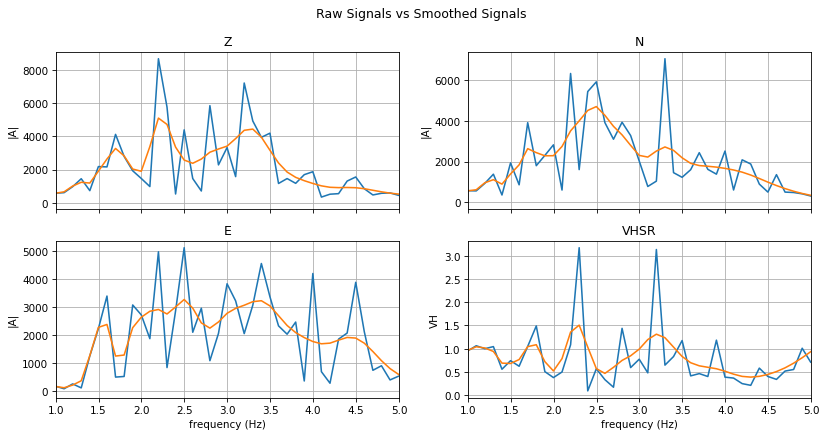

In [14]:
smoothed_spectrum = [[spectrum_zs[0], spectrum_ns[0]],
                     [spectrum_es[0], spectrum_vhsrs[0]]]
spectrum = [[spectrum_z[0], spectrum_n[0]],
            [spectrum_e[0], spectrum_vhsr[0]]]

title = [['Z','N'],['E','VHSR']]
ylabel= [['|A|','|A|'],['|A|','VH']]

freq_limit = [1, 5]


rawVsmoothed(fftfreq, spectrum, smoothed_spectrum, title, ylabel, freq_limit)

# Calculate average spectrum
median, mean, dan average dengan axis 0 menghasilkan nilai yang sama

In [15]:
Z_average = np.mean(spectrum_zs, axis=0)
N_average = np.mean(spectrum_ns, axis=0)
E_average = np.mean(spectrum_es, axis=0)
VHSR_average = np.mean(spectrum_vhsrs, axis=0)

Text(0.5, 0, 'frequency (Hz)')

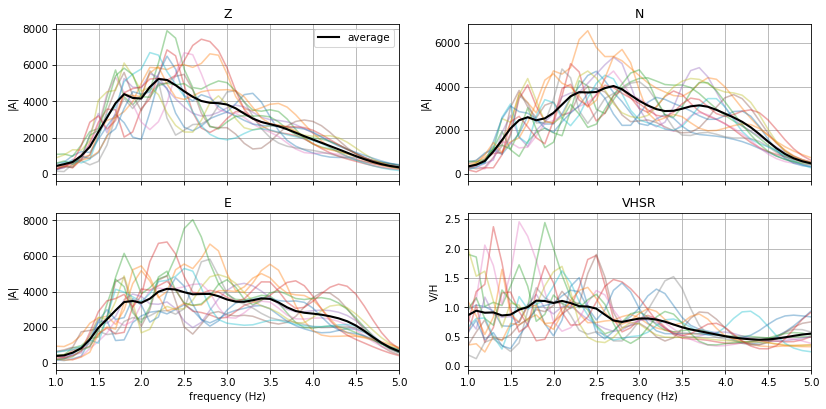

In [16]:
fig,ax = plt.subplots(2, 2, figsize=(13,6), dpi=75, sharey=False, sharex=True)

for ii in range(len(window_list)):
  ax[0,0].plot(fftfreq, spectrum_zs[ii], alpha=0.4)
  ax[0,1].plot(fftfreq, spectrum_ns[ii], alpha=0.4)
  ax[1,0].plot(fftfreq, spectrum_es[ii], alpha=0.4)
  ax[1,1].plot(fftfreq, spectrum_vhsrs[ii], alpha=0.4)
  title = [['Z','N'],['E','VHSR']]
  ylabel= [['|A|','|A|'],['|A|','V/H']]
  for i in range(2):
    for j in range(2):
      ax[i,j].grid('both')
      ax[i,j].set_title(title[i][j])
      ax[i,j].set_ylabel(ylabel[i][j])

ax[0,0].plot(fftfreq, Z_average,'k',lw=2,label='average')
ax[0,1].plot(fftfreq, N_average,'k',lw=2)
ax[1,0].plot(fftfreq, E_average,'k',lw=2)
ax[1,1].plot(fftfreq, VHSR_average,'k',lw=2)

ax[0,0].legend()
ax[0,0].set_xlim(1,5)
ax[1,0].set_xlabel("frequency (Hz)")
ax[1,1].set_xlabel("frequency (Hz)")

# Get dominant frequency and maximum spectrum amplitude

In [17]:
freq_psd, psd = peakdetect(fftfreq, Z_average)
print(freq_psd, psd)

2.197802197802198 5229.300078545886


# Get maximum V/H

In [18]:
freq_vh, vh = peakdetect(fftfreq, VHSR_average)
print(freq_vh, vh)

1.7982017982017982 1.113985901071549


# Calculate Energy
[link text](https://www.researchgate.net/publication/271966581_Multi-Attribute_Analysis_of_a_Low-Frequency_Passive_Seismic_Method_for_Hydrocarbon_Indicator_Prospecting_Case_Study_in_'CEMARA'_Field_Cirebon_West_Java_Indonesia)

These attributes measure the integral of the vertical component spectra (Z) by considering the ocean wave peak (OWP) and anthropogenic noise effect to decide the integral boundary (Walker, 2008). We used a minimum between 1–1.7 Hz as the minimum boundary and a maximum at 3.7 Hz as the area of the integral (Fig. 4)

In [19]:
minimum_frequency = 1.0 # Hz
maximum_frequency = 4.0 # Hz

mask = fftfreq[(fftfreq >= minimum_frequency) & (fftfreq <= maximum_frequency)]
indices = np.where(np.isin(fftfreq, mask))[0]
masked_psd = Z_average[indices]

df = 0.02
energy = sum(masked_psd * df) / (maximum_frequency - minimum_frequency)
print(energy)

647.9396167135451


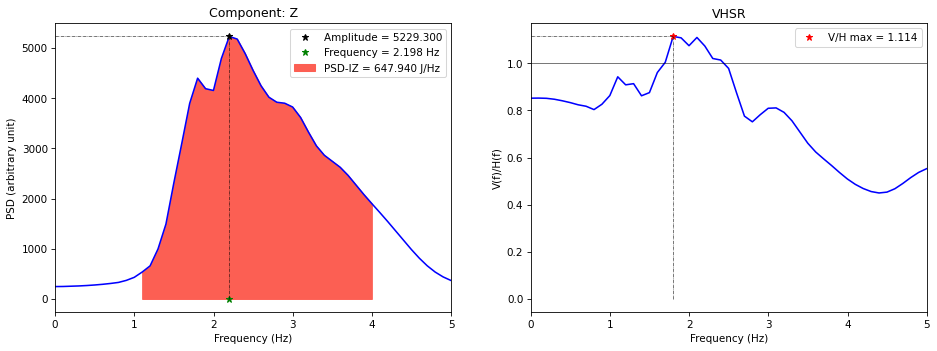

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(15,5), dpi=75, sharey=False, sharex=True)

ax[0].plot(fftfreq, Z_average, "b")
ax[0].plot(freq_psd, psd, "*k", label=f"Amplitude = {psd:.3f}")
ax[0].plot(freq_psd, 0, "*g", label=f"Frequency = {freq_psd:.3f} Hz")
ax[0].plot([0, freq_psd], [psd, psd], "-.k", linewidth=0.5)
ax[0].plot([freq_psd, freq_psd], [0, psd], "-.k", linewidth=0.5)
ax[0].fill_between(fftfreq, Z_average,
                 where = (fftfreq >= minimum_frequency) & (fftfreq <= maximum_frequency),
                 color = '#fc5f53',
                 label=f"PSD-IZ = {energy:.3f} J/Hz")
ax[0].set_xlim(0, 5)
ax[0].set_title("Component: Z")
ax[0].set_xlabel("Frequency (Hz)")
ax[0].set_ylabel("PSD (arbitrary unit)")
ax[0].legend()

ax[1].plot(fftfreq, VHSR_average, 'b')
ax[1].plot(freq_vh, vh, '*r', label=f"V/H max = {vh:.3f}")
ax[1].plot([0, freq_vh], [vh, vh], "-.k", linewidth=0.5)
ax[1].plot([freq_vh, freq_vh], [0, vh], "-.k", linewidth=0.5)
ax[1].axhline(y = 1, color = 'k', linewidth=0.5)
ax[1].set_title("VHSR")
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_ylabel("V(f)/H(f)")
ax[1].legend()

# LFPS Attributes

In [21]:
import pandas as pd

attributes = pd.DataFrame({
  "ID": [f"{stream[0].stats.network}_{stream[0].stats.station}"],
  "Amplitude": [f"{psd:.3f}"],
  "Energy": [f"{energy:.3f}"],
  "Frequency": [f"{freq_psd:.3f}"],
  "VHSR": [f"{vh:.3f}"]
})
attributes

,ID,Amplitude,Energy,Frequency,VHSR
0,HG_16,5229.300,647.940,2.198,1.114
